In [1]:
# %% load libraries
import SuPy.SuPy_module as sp
import os
import glob
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import copy
# import collections
# reload(sp)

# %% initialise SUEWS settings
# dir_input = './Input'
dir_start = '../SampleRun/'
dict_mod_cfg, dict_state_init = sp.init_SUEWS_dict(dir_start)
df_state_init = df.from_dict(dict_state_init).T
df_state_init.index.set_names('grid', inplace=True)

# load met forcing
filecode = dict_mod_cfg['filecode']
tstep = dict_state_init[1]['tstep']
metfile_pattern = 'Input/{}*{}*txt'.format(filecode, tstep / 60)
list_file_MetForcing = glob.glob(os.path.join(dir_start, metfile_pattern))
# load as DataFrame:
df_forcing = sp.load_SUEWS_MetForcing_df(list_file_MetForcing[1])
# load as dict (faster for simulation if performance is heavily concerned)
# dict_forcing = sp.load_SUEWS_MetForcing_dict(list_file_MetForcing[1])
# dict_forcing.keys()[-1]
# serx = df_forcing.loc[1]
# serx.append(df_forcing.loc[3])

In [18]:
# %% main calulation:
# compact form:
reload(sp)
# df_state = None
# df_output = None
df_forcing_part = df_forcing.iloc[:500]
# dict_state_init[1]['xwf'] = 0
# %timeit dict_output, dict_state = sp.run_suews(df_forcing_part, {1: dict_state_init[1]})

df_state_init.loc[1, 'xwf'] = 0
dict_output, dict_state = sp.run_suews_df(df_forcing_part, df_state_init)

# %% post-processing of model ouptuts:
# convert dict of raw output to easier DataFrame:
# {grid: Dataframe by group ({'SUEWS','ESTM','snow'})}
df_output = sp.pack_df_output(dict_output)
df_state = sp.pack_df_state(dict_state)

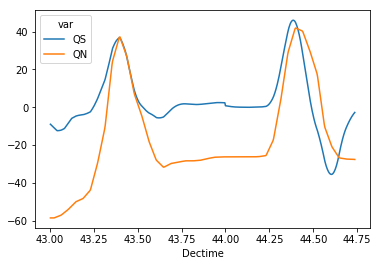

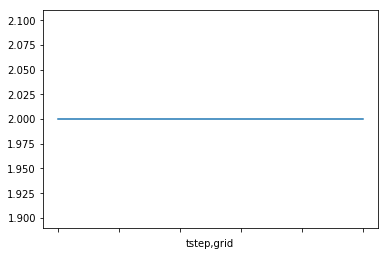

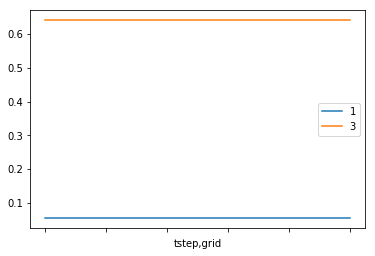

In [26]:
# %% plot some variables
idx = pd.IndexSlice
# output
xx = df_output.loc[idx[:, 1], [('datetime', 'Dectime'),
                       ('SUEWS', 'QS'), ('SUEWS', 'QN')]]
xx.columns = xx.columns.droplevel()
xx.plot(x='Dectime')
plt.show()

# state variable TODO: df_state

# entry with single value
y1 = df_state.loc[idx[:, 1], 'aerodynamicresistancemethod'].plot()
plt.show()
# entry with value arrays
y2 = df_state.loc[idx[:, 1], 'state'].apply(
    pd.Series).loc[:, [1, 3]].plot()
plt.show()

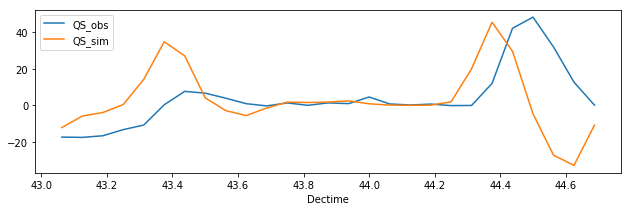

In [20]:
# %% comparison
# load observations
list_file_Obs = glob.glob(os.path.join(
    dir_start, 'Obs/{}*txt'.format(filecode)))
res_obs = pd.read_table(list_file_Obs[0])
res_obs.rename(columns={'dectime': 'Dectime', 'QgHFP': 'QS_obs'}, inplace=True)

# specify the variable for comparison
res_sim = df_output.loc[idx[:, 1], [
    ('datetime', 'Dectime'), ('SUEWS', 'QS'), ('SUEWS', 'QN')]]
res_sim.columns = res_sim.columns.droplevel()
res_sim.rename(columns={'QS': 'QS_sim'}, inplace=True)
# merge two DF's
res_comp = res_obs.copy()
res_comp = res_obs.merge(res_sim, on='Dectime')
res_comp.head()
res_comp.plot(x='Dectime', y=['QS_obs', 'QS_sim'],
              kind='line', figsize=(10.5, 3))
plt.show()


#

In [34]:
reload(sp);

In [35]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [36]:
%lprun -f sp.run_suews_df sp.run_suews_df(df_forcing_part, df_state_init)

Timer unit: 1e-06 s

Total time: 3.69369 s
File: SuPy/SuPy_module.py
Function: run_suews_df at line 1297

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1297                                           def run_suews_df(df_forcing, df_init):
  1298                                               # initialise dicts for holding results and model states
  1299         1            3      3.0      0.0      dict_state = {}
  1300         1            1      1.0      0.0      dict_output = {}
  1301                                               # start tstep retrived from forcing data
  1302         1           21     21.0      0.0      t_start = df_forcing.index[0]
  1303                                               # grid list determined by initial states
  1304         1            2      2.0      0.0      grid_list = df_init.index
  1305                                               # dict_state is used to save model states for later use
  1306         1            2      2

In [37]:
%lprun -f sp.suews_cal_tstep_df sp.run_suews_df(df_forcing_part, df_state_init)

Timer unit: 1e-06 s

Total time: 3.38107 s
File: SuPy/SuPy_module.py
Function: suews_cal_tstep_df at line 1266

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1266                                           def suews_cal_tstep_df(series_state_start, series_met_forcing_tstep):
  1267                                               # use single dict as input for suews_cal_main
  1268                                               # series_input_raw = pd.concat(
  1269                                               #     [series_state_start.to_dict(),
  1270                                               #      series_met_forcing_tstep.rename(series_state_start.name)])
  1271       500        84296    168.6      2.5      dict_input = series_state_start.to_dict()
  1272       500          738      1.5      0.0      dict_input.update(
  1273       500        66597    133.2      2.0          series_met_forcing_tstep.to_dict())
  1274                                               